## **Importing libraries and datasets**

In [93]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [8]:
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [9]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [10]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [11]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


## **Data Preparation**

In [12]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0


In [13]:
## create data set with RFM variables

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum()})               # Monetary Value           


df_rfm.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value'}, inplace=True)

In [14]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value
0,CS1112,62.0,15,1012
1,CS1113,36.0,20,1490
2,CS1114,33.0,19,1432
3,CS1115,12.0,22,1659
4,CS1116,204.0,13,857


In [15]:
## create data set with CLV variables

df_clv = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days})       # AOU

df_clv.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU'}, inplace=True)

df_clv['ticket_size'] = df_clv['monetary_value'] / df_clv['frequency']

In [16]:
df_clv = df_clv.reset_index()
df_clv.head()

,customer_id,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,62.0,15,1012,1309,67.466667
1,CS1113,36.0,20,1490,1354,74.500000
2,CS1114,33.0,19,1432,1309,75.368421
3,CS1115,12.0,22,1659,1303,75.409091
4,CS1116,204.0,13,857,1155,65.923077


## **Calculating response rate**

In [17]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


In [ ]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [18]:
## merging two data sets - RFM

df_modeling_rfm = pd.merge(df_response,df_rfm)
df_modeling_rfm.head()

,customer_id,response,recency,frequency,monetary_value
0,CS1112,0,62.0,15,1012
1,CS1113,0,36.0,20,1490
2,CS1114,1,33.0,19,1432
3,CS1115,1,12.0,22,1659
4,CS1116,1,204.0,13,857


In [19]:
## merging two data sets - CLV

df_modeling_clv = pd.merge(df_response,df_clv)
df_modeling_clv.head()

,customer_id,response,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,0,62.0,15,1012,1309,67.466667
1,CS1113,0,36.0,20,1490,1354,74.500000
2,CS1114,1,33.0,19,1432,1309,75.368421
3,CS1115,1,12.0,22,1659,1303,75.409091
4,CS1116,1,204.0,13,857,1155,65.923077


## **Creating train and test dataset**

In [20]:
## spliting dataframe into X and y

X_rfm = df_modeling_rfm.drop(columns=['response','customer_id'])
y_rfm = df_modeling_rfm['response']

X_clv = df_modeling_clv.drop(columns=['response','customer_id'])
y_clv = df_modeling_clv['response']

In [21]:
## creating train and test dataset

X_train_rfm, X_test_rfm, y_train_rfm, y_test_rfm = train_test_split(X_rfm, y_rfm, test_size=0.3, random_state=0)
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.3, random_state=0)

In [ ]:
for i, col_i in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
  for j, col_j in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_rfm, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

In [ ]:
for i, col_i in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
  for j, col_j in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_clv, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

## **Fixing imbalanced with SMOTE**

In [22]:
sm = SMOTE(random_state=0)

sm.fit(X_train_rfm, y_train_rfm)
X_SMOTE_rfm, y_SMOTE_rfm = sm.fit_resample(X_train_rfm, y_train_rfm)

sm.fit(X_train_clv, y_train_clv)
X_SMOTE_clv, y_SMOTE_clv = sm.fit_resample(X_train_clv, y_train_clv)

# **Evaluation**

In [33]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from sklearn import metrics

**RFM**

In [70]:
algo=[
    [KNeighborsClassifier(n_neighbors=5), 'KNeighborsClassifier'], 
    [LogisticRegression(solver='lbfgs'), 'LogisticRegression'],
    [xgb.XGBClassifier(objective='binary:logistic'), 'XGBoot'], 
    [Perceptron(), 'Perceptron'],
    [DecisionTreeClassifier(min_samples_split=10), 'DecisionTreeClassifier'],
    [GradientBoostingClassifier(), 'GradientBoostingClassifier'],
    [RandomForestClassifier(), 'RandomForestClassifier'],
    [BaggingClassifier(), 'BaggingClassifier'],
    [AdaBoostClassifier(), 'AdaBoostClassifier'],
    [GaussianNB(), 'GaussianNB'],
    [MLPClassifier(), 'MLPClassifier'],
   # [SVC(kernel='linear'), 'SVC_linear'], 
   #[GaussianProcessClassifier(), 'GaussianProcessClassifier']
]
model_scores=[]
for a in algo:
    model = a[0]
    predicted_y = []
    expected_y = []
    predicted_y_train = []
    expected_y_train = []



    model.fit(X_SMOTE_rfm , y_SMOTE_rfm)
    score=model.score(X_test_rfm, y_test_rfm)
    model_scores.append([score, a[1]])
    predictions = model.predict(X_SMOTE_rfm)
    y_pred=model.predict(X_test_rfm)
    predicted_y.extend(y_pred)
    expected_y.extend(y_test_rfm)    
    predicted_y_train.extend(predictions)
    expected_y_train.extend(y_SMOTE_rfm)
    report_test = classification_report(expected_y, predicted_y)
    print(f'{a[1]:20} score: {score:.04f}')
    print(metrics.confusion_matrix(y_test_clv, y_pred))
    print(metrics.classification_report(y_test_clv, y_pred))
    print('AUC Score train',roc_auc_score(expected_y_train,predicted_y_train))  
    print('AUC Score test',roc_auc_score(expected_y,predicted_y))  
    print('-' * 100)
    
print(model_scores)

KNeighborsClassifier score: 0.7018
[[1355  493]
 [ 123   95]]
              precision    recall  f1-score   support

           0       0.92      0.73      0.81      1848
           1       0.16      0.44      0.24       218

    accuracy                           0.70      2066
   macro avg       0.54      0.58      0.53      2066
weighted avg       0.84      0.70      0.75      2066

AUC Score train 0.8724082934609251
AUC Score test 0.5845024623694348
----------------------------------------------------------------------------------------------------
LogisticRegression   score: 0.6157
[[1116  732]
 [  62  156]]
              precision    recall  f1-score   support

           0       0.95      0.60      0.74      1848
           1       0.18      0.72      0.28       218

    accuracy                           0.62      2066
   macro avg       0.56      0.66      0.51      2066
weighted avg       0.87      0.62      0.69      2066

AUC Score train 0.6637047163362954
AUC Score test 0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

DecisionTreeClassifier score: 0.7541
[[1494  354]
 [ 154   64]]
              precision    recall  f1-score   support

           0       0.91      0.81      0.85      1848
           1       0.15      0.29      0.20       218

    accuracy                           0.75      2066
   macro avg       0.53      0.55      0.53      2066
weighted avg       0.83      0.75      0.79      2066

AUC Score train 0.9390521758942811
AUC Score test 0.5510097700464673
----------------------------------------------------------------------------------------------------
GradientBoostingClassifier score: 0.6273
[[1157  691]
 [  79  139]]
              precision    recall  f1-score   support

           0       0.94      0.63      0.75      1848
           1       0.17      0.64      0.27       218

    accuracy                           0.63      2066
   macro avg       0.55      0.63      0.51      2066
weighted avg       0.85      0.63      0.70      2066

AUC Score train 0.753360674413306
AUC Score 

**CLV**

In [61]:
algo=[
    [KNeighborsClassifier(n_neighbors=5), 'KNeighborsClassifier'], 
    [LogisticRegression(solver='lbfgs'), 'LogisticRegression'],
    [xgb.XGBClassifier(objective='binary:logistic'), 'XGBoot'], 
    [Perceptron(), 'Perceptron'],
    [DecisionTreeClassifier(min_samples_split=10), 'DecisionTreeClassifier'],
    [GradientBoostingClassifier(), 'GradientBoostingClassifier'],
    [RandomForestClassifier(), 'RandomForestClassifier'],
    [BaggingClassifier(), 'BaggingClassifier'],
    [AdaBoostClassifier(), 'AdaBoostClassifier'],
    [GaussianNB(), 'GaussianNB'],
    [MLPClassifier(), 'MLPClassifier'],
   # [SVC(kernel='linear'), 'SVC_linear'], 
   #[GaussianProcessClassifier(), 'GaussianProcessClassifier']
]
model_scores=[]
for a in algo:
    model = a[0]
    predicted_y = []
    expected_y = []
    predicted_y_train = []
    expected_y_train = []



    model.fit(X_SMOTE_clv, y_SMOTE_clv)
    score=model.score(X_test_clv, y_test_clv)
    model_scores.append([score, a[1]])
    predictions = model.predict(X_SMOTE_clv)
    y_pred=model.predict(X_test_clv)
    predicted_y.extend(y_pred)
    expected_y.extend(y_test_clv)    
    predicted_y_train.extend(predictions)
    expected_y_train.extend(y_SMOTE_clv)
    report_test = classification_report(expected_y, predicted_y)
    print(f'{a[1]:20} score: {score:.04f}')
    print(metrics.confusion_matrix(y_test_clv, y_pred))
    print(metrics.classification_report(y_test_clv, y_pred))
    print('AUC Score train',roc_auc_score(expected_y_train,predicted_y_train))  
    print('AUC Score test',roc_auc_score(expected_y,predicted_y))  
    print('-' * 100)
    
print(model_scores)

KNeighborsClassifier score: 0.6989
[[1343  505]
 [ 117  101]]
              precision    recall  f1-score   support

           0       0.92      0.73      0.81      1848
           1       0.17      0.46      0.25       218

    accuracy                           0.70      2066
   macro avg       0.54      0.60      0.53      2066
weighted avg       0.84      0.70      0.75      2066

AUC Score train 0.8856231487810435
AUC Score test 0.5950171770125897
----------------------------------------------------------------------------------------------------
LogisticRegression   score: 0.6655
[[1241  607]
 [  84  134]]
              precision    recall  f1-score   support

           0       0.94      0.67      0.78      1848
           1       0.18      0.61      0.28       218

    accuracy                           0.67      2066
   macro avg       0.56      0.64      0.53      2066
weighted avg       0.86      0.67      0.73      2066

AUC Score train 0.6894508999772158
AUC Score test 0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

DecisionTreeClassifier score: 0.7633
[[1507  341]
 [ 148   70]]
              precision    recall  f1-score   support

           0       0.91      0.82      0.86      1848
           1       0.17      0.32      0.22       218

    accuracy                           0.76      2066
   macro avg       0.54      0.57      0.54      2066
weighted avg       0.83      0.76      0.79      2066

AUC Score train 0.9516974253816359
AUC Score test 0.5682885539536916
----------------------------------------------------------------------------------------------------
GradientBoostingClassifier score: 0.6573
[[1224  624]
 [  84  134]]
              precision    recall  f1-score   support

           0       0.94      0.66      0.78      1848
           1       0.18      0.61      0.27       218

    accuracy                           0.66      2066
   macro avg       0.56      0.64      0.53      2066
weighted avg       0.86      0.66      0.72      2066

AUC Score train 0.7599681020733652
AUC Score

In [114]:
from sklearn.model_selection import GridSearchCV

params = {"C": np.logspace(-4, 4, 20),
          "solver": ["liblinear"]}

lr_clf = LogisticRegression(solver='liblinear', class_weight='balanced')

lr_cv = GridSearchCV(lr_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=5)
lr_cv.fit(X_SMOTE_clv, y_SMOTE_clv)
best_params = lr_cv.best_params_
print(f"Best parameters: {best_params}")
lr_clf = LogisticRegression(**best_params)

lr_clf.fit(X_SMOTE_clv, y_SMOTE_clv)
lr_clf.score(X_SMOTE_clv,y_SMOTE_clv)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'C': 206.913808111479, 'solver': 'liblinear'}


0.6787072243346007

In [118]:
print('logistic regression model - SMOTE RFM')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_rfm = logreg.fit(X_SMOTE_rfm, y_SMOTE_rfm)
predictions = logreg_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train)


predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_rfm.predict(X_test_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)


logistic regression model - SMOTE RFM
training set
              precision    recall  f1-score   support

           0       0.68      0.61      0.64      4997
           1       0.65      0.72      0.68      4997

    accuracy                           0.66      9994
   macro avg       0.67      0.66      0.66      9994
weighted avg       0.67      0.66      0.66      9994

test set
              precision    recall  f1-score   support

           0       0.95      0.61      0.74      1240
           1       0.17      0.71      0.27       137

    accuracy                           0.62      1377
   macro avg       0.56      0.66      0.51      1377
weighted avg       0.87      0.62      0.70      1377



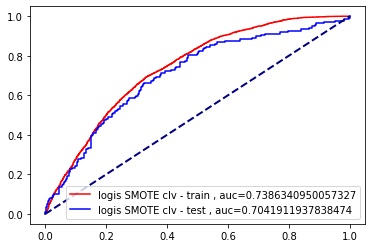

In [117]:
y_score_train = logreg_model_SMOTE_clv.decision_function(X_SMOTE_clv)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE_clv, y_score_train)
auc_train = roc_auc_score(y_SMOTE_clv, y_score_train)
plt.plot(fpr_train, tpr_train, color='red', label = 'logis SMOTE clv - train , auc='+str(auc_train))

y_score_test = logreg_model_SMOTE_clv.decision_function(X_test_clv)
fpr_train, tpr_train, _ = roc_curve(y_test_clv, y_score_test)
auc_test = roc_auc_score(y_test_clv, y_score_test)
plt.plot(fpr_train, tpr_train, color='Blue', label = 'logis SMOTE clv - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [108]:
from sklearn.model_selection import GridSearchCV

params = {"C": np.logspace(-4, 4, 20),
          "solver": ["liblinear"]}

lr_clf_xg = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=150,
 max_depth=3,
 gamma=0.1,
 colsample_bytree=0.7)

lr_cv_xg = GridSearchCV(lr_clf_xg, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=5)
lr_cv_xg.fit(X_SMOTE_clv, y_SMOTE_clv)
best_params = lr_cv_xg.best_params_
print(f"Best parameters: {best_params}")
lr_clf_xg = xgb.XGBClassifier(**best_params)

lr_clf_xg.fit(X_SMOTE_clv, y_SMOTE_clv)
lr_clf_xg.score(X_SMOTE_clv,y_SMOTE_clv)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'C': 0.0001, 'solver': 'liblinear'}


0.751550930558335

In [112]:
print('XGBoost model - SMOTE CLV')


predicted_y = []
expected_y = []

xgb_model_SMOTE_clv = lr_clf_xg.fit(X_SMOTE_clv.to_numpy(), y_SMOTE_clv, early_stopping_rounds=5, eval_set=[(X_test_clv.to_numpy(), y_test_clv)])
predictions =  xgb_model_SMOTE_clv.predict(X_SMOTE_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_clv.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE CLV
[0]	validation_0-error:0.341322
Will train until validation_0-error hasn't improved in 5 rounds.
[1]	validation_0-error:0.355846
[2]	validation_0-error:0.384168
[3]	validation_0-error:0.384168
[4]	validation_0-error:0.381264
[5]	validation_0-error:0.381264
Stopping. Best iteration:
[0]	validation_0-error:0.341322

training set
              precision    recall  f1-score   support

           0       0.69      0.67      0.68      4997
           1       0.68      0.69      0.68      4997

    accuracy                           0.68      9994
   macro avg       0.68      0.68      0.68      9994
weighted avg       0.68      0.68      0.68      9994

test set
              precision    recall  f1-score   support

           0       0.94      0.66      0.78      1240
           1       0.17      0.64      0.27       137

    accuracy                           0.66      1377
   macro avg       0.56      0.65      0.52      1377
weighted avg       0.87      0.66    

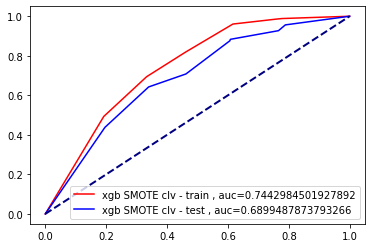

In [113]:
y_score_train = xgb_model_SMOTE_clv.predict_proba(X_SMOTE_clv.to_numpy())
fpr_train, tpr_train, _ = roc_curve(y_SMOTE_clv, y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE_clv, y_score_train[:,1])
plt.plot(fpr_train, tpr_train, color='red', label = 'xgb SMOTE clv - train , auc='+str(auc_train))

y_score_test = xgb_model_SMOTE_clv.predict_proba(X_test_clv.to_numpy())
fpr_train, tpr_train, _ = roc_curve(y_test_clv, y_score_test[:,1])
auc_test = roc_auc_score(y_test_clv, y_score_test[:,1])
plt.plot(fpr_train, tpr_train, color='Blue', label = 'xgb SMOTE clv - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

# **Evaluation 2 **


In [88]:
## creating train and test dataset

X_train_rfm, X_test_rfm, y_train_rfm, y_test_rfm = train_test_split(X_rfm, y_rfm, test_size=0.2, random_state=0)
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.2, random_state=0)

In [91]:
sm = SMOTE(random_state=0)

sm.fit(X_train_rfm, y_train_rfm)
X_SMOTE_rfm, y_SMOTE_rfm = sm.fit_resample(X_train_rfm, y_train_rfm)

sm.fit(X_train_clv, y_train_clv)
X_SMOTE_clv, y_SMOTE_clv = sm.fit_resample(X_train_clv, y_train_clv)

In [101]:
print('XGBoost model - SMOTE CLV')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.1,
 n_estimators=300,
 max_depth=1,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE_clv = xgb_model.fit(X_SMOTE_clv.to_numpy(), y_SMOTE_clv, early_stopping_rounds=5, eval_set=[(X_test_clv.to_numpy(), y_test_clv)])
predictions =  xgb_model_SMOTE_clv.predict(X_SMOTE_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_clv.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE CLV
[0]	validation_0-auc:0.666482
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.666482
[2]	validation_0-auc:0.666482
[3]	validation_0-auc:0.666182
[4]	validation_0-auc:0.671159
[5]	validation_0-auc:0.67319
[6]	validation_0-auc:0.67319
[7]	validation_0-auc:0.710142
[8]	validation_0-auc:0.711064
[9]	validation_0-auc:0.717833
[10]	validation_0-auc:0.717974
[11]	validation_0-auc:0.723072
[12]	validation_0-auc:0.723072
[13]	validation_0-auc:0.723578
[14]	validation_0-auc:0.7253
[15]	validation_0-auc:0.726113
[16]	validation_0-auc:0.726324
[17]	validation_0-auc:0.728249
[18]	validation_0-auc:0.730363
[19]	validation_0-auc:0.729512
[20]	validation_0-auc:0.729082
[21]	validation_0-auc:0.729053
[22]	validation_0-auc:0.728844
[23]	validation_0-auc:0.730062
Stopping. Best iteration:
[18]	validation_0-auc:0.730363

training set
              precision    recall  f1-score   support

           0       0.75      0.52      0.61      4997
 

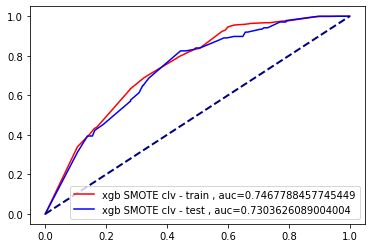

In [103]:
y_score_train = xgb_model_SMOTE_clv.predict_proba(X_SMOTE_clv.to_numpy())
fpr_train, tpr_train, _ = roc_curve(y_SMOTE_clv, y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE_clv, y_score_train[:,1])
plt.plot(fpr_train, tpr_train, color='red', label = 'xgb SMOTE clv - train , auc='+str(auc_train))

y_score_test = xgb_model_SMOTE_clv.predict_proba(X_test_clv.to_numpy())
fpr_train, tpr_train, _ = roc_curve(y_test_clv, y_score_test[:,1])
auc_test = roc_auc_score(y_test_clv, y_score_test[:,1])
plt.plot(fpr_train, tpr_train, color='Blue', label = 'xgb SMOTE clv - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

#**Result**

AUC Score train = 0.746

AUC Score test = 0.730